In [36]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import itertools
import functools
from matplotlib.animation import FuncAnimation, PillowWriter, MovieWriter 
from IPython import display
from copy import copy, deepcopy
from time import time

In [147]:
def generate_set_a(number_of_points = 100, left = -100, right = 100):
    return np.array([[random.uniform(left, right), random.uniform(left, right)] for _ in range(number_of_points)])


def generate_set_b(number_of_points = 100, O = (0, 0), R = 10):
    points = [[None, None] for _ in range(number_of_points)]
    
    for i in range(number_of_points):
        t = random.uniform(0, 2*np.pi)
        points[i][0] = R * np.cos(t) + O[0]
        points[i][1] = R * np.sin(t) + O[1]
    
    return np.array(points)


def generate_set_c(number_of_points = 100, lower_left_corner = (-10, -10), upper_right_corner = (10, 10)):
    l = lower_left_corner[0]
    r = upper_right_corner[0]
    u = upper_right_corner[1]
    d = lower_left_corner[1]

    points = [[] for _ in range(number_of_points)]
    
    for i in range(number_of_points):
        side = random.randint(1, 4)
        if side == 1:
            x, y = random.uniform(l, r), d
        elif side == 2:
            x, y = l, random.uniform(d, u)
        elif side == 3:
            x, y = random.uniform(l, r), u
        elif side == 4:
            x, y = r, random.uniform(d, u)
        points[i] = [x, y]
    
    return np.array(points)


def generate_set_d(lower_left_corner = (0, 0), a = 10, on_axes = 25, on_diagonal = 20):
    points = [[None, None] for _ in range(94)]
    x0 = 0
    y0 = 0
    a = 10
    
    for i, element in enumerate(itertools.product([x0, x0 + a], [y0, y0 + a])):
        points[i] = element
    
    for i in range(on_axes):
        points[4 + i] = [random.uniform(x0, x0 + a), y0]
        points[4 + on_axes + i] = [x0, random.uniform(y0, y0 + a)]
        
    p = 4 + on_axes * 2
    
    for i in range(on_diagonal):
        b = y0 - x0
        x = random.uniform(x0, x0 + a)
        y = x + b
        points[p + i] = [x, y]
        
        b = y0 + x0 + a
        x = random.uniform(x0, x0 + a)
        y = -x + b
        points[p + on_diagonal + i] = [x, y]
            
    return np.array(points)


def generate_all_sets():
    return [generate_set_a(), generate_set_b(),  generate_set_c(),  generate_set_d()]

def plot(points):
    plt.scatter(points[:,0], points[:, 1], s=10)

In [38]:
set_of_points = generate_all_sets()

### Zestaw 1.

<IPython.core.display.Javascript object>


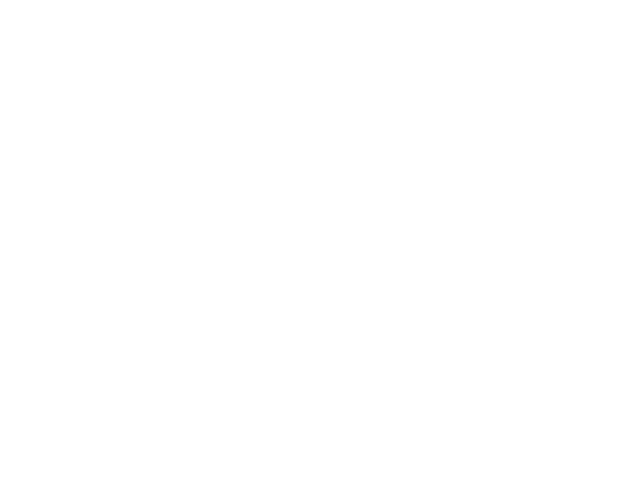

In [39]:
plot(set_of_points[0])

### Zestaw 2.

In [40]:
plot(set_of_points[1])

### Zestaw 3.

In [41]:
plot(set_of_points[2])

### Zestaw.4

In [42]:
plot(set_of_points[3])

In [43]:
def det3x3(a, b, c):
    return (a[0]*b[1]) + (a[1]*c[0]) + (b[0]*c[1])- (c[0]*b[1]) - (b[0]*a[1]) - (a[0]*c[1])


def orientation(a, b, c, tolerance = 1e-12):
    det = det3x3(a, b, c)
    if abs(det) < tolerance:
        return 0
    elif det < 0:
        return 1
    else:
        return -1
    
    
def dist(a, b):
        return ((a[0]-b[0])**2 + (a[1]-b[1])**2)**.5         

    
def sort_by_polar_angle(points, p0):  
    def compare(p1, p2):
        d = orientation(p0, p1, p2)
        if d != 0:
            return d
        else:
            if dist(p0, p1) > dist(p0, p2):
                return 1
            else:
                return -1

    presorted_points = sorted(points, key=functools.cmp_to_key(compare))
    
    to_remove = set()
    for i in range(1, len(presorted_points)):
        if orientation(p0, presorted_points[i-1],presorted_points[i]) == 0:
            to_remove.add(i - 1)
    
    sorted_points = [presorted_points[i] for i in range(len(presorted_points)) if i not in to_remove]
    

    return sorted_points

def graham_scan(points):
    start = time()
    
    idx, p0 = min(enumerate(points), key=lambda p:(p[1][1], p[1][0]))
#     print(p0, points[0], points[idx])
    p0 = copy(p0)
    tmp = copy(points[0])
    points[0] = copy(points[idx])
    points[idx] = tmp
#     print(p0, points[0], points[idx])



    sorted_points = sort_by_polar_angle(points[1:], p0)
    
    
    
    stack = []
    stack.append(copy(p0))
    stack.append(copy(sorted_points[0]))
    stack.append(copy(sorted_points[1]))
    
    intermediate_steps = [np.array(copy(stack))]
    
    m = len(sorted_points)
        
    for i in range(2, m):
        while len(stack) >= 2 and orientation(stack[-2], stack[-1], sorted_points[i]) != -1:
            stack.pop()
            intermediate_steps.append(np.array(copy(stack)))
        stack.append(copy(sorted_points[i]))
        intermediate_steps.append(np.array(copy(stack)))
    
    end = time()

    return np.array(stack), intermediate_steps, end - start

def compare(p0, p1, p2):
    d = orientation(p0, p1, p2)
    if d != 0:
        return d
    else:
        if dist(p0, p1) > dist(p0, p2):
            return -1
        else:
            return 1

def jarvis_march(points):
    start = time()
    
    idx_prev, p0 = min(enumerate(points), key=lambda p:(p[1][1], p[1][0]))

    
    stack = [p0]
    intermediate_steps = [copy(np.array(stack))]
    m = len(points)

    
    while True:
        p1, idx_p1 = points[0], 0
        for i in range(m):
            if i == idx_prev:
                continue
            cmp = compare(stack[-1], p1, points[i])
            if cmp == 1:
                intermediate_steps.append(copy(np.array(stack+[p1])))
                p1, idx_p1 = points[i], i
        idx_prev = idx_p1
        
        if p1[0] == p0[0] and p1[1] == p0[1]:
            break
            
        stack.append(p1)
        intermediate_steps.append(copy(np.array(stack)))
    
    end = time()
    
    return np.array(stack), intermediate_steps, end - start

def plot_hull(hull):
    plt.plot(hull[:,0], hull[:,1], c='r', marker='o')
    plt.plot([hull[0][0], hull[-1][0]], [hull[0][1], hull[-1][1]], c='r', marker='o')

<IPython.core.display.Javascript object>


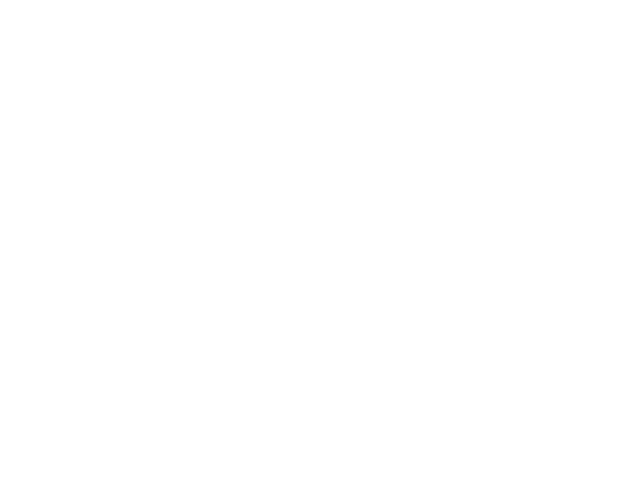

In [44]:
%matplotlib notebook
a = generate_set_a()
plot(a)
hull, steps, t = jarvis_march(a)
plot_hull(hull)

In [45]:
def visualize(points, steps):
    
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    ax.scatter(points[:,0], points[:,1])

    def update(i):
        ax.clear()
        ax.scatter(points[:,0], points[:,1])
        label = 'step {0}'.format(i + 1)
        ax.plot(steps[i][:, 0], steps[i][:, 1], 'ro-')
        ax.plot(steps[i][-1, 0], steps[i][-1, 1], 'go-')

        ax.set_xlabel(label)

    return FuncAnimation(fig, update, repeat=True, frames=np.arange(0, len(steps)), interval=1000)

def hull_to_file(hull, name):
    with open(name+'.txt', 'w') as file:
        file.write('\n'.join(str(x)+','+str(y) for x, y in hull))

### Algorytm Grahama

In [46]:
record = [graham_scan(p) for p in set_of_points]

#### Zestaw 1.

<IPython.core.display.Javascript object>


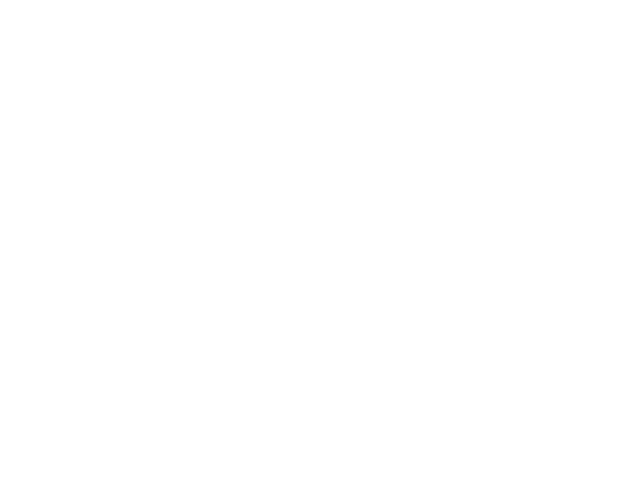

In [47]:
i = 0
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

#### Zestaw 2.

<IPython.core.display.Javascript object>


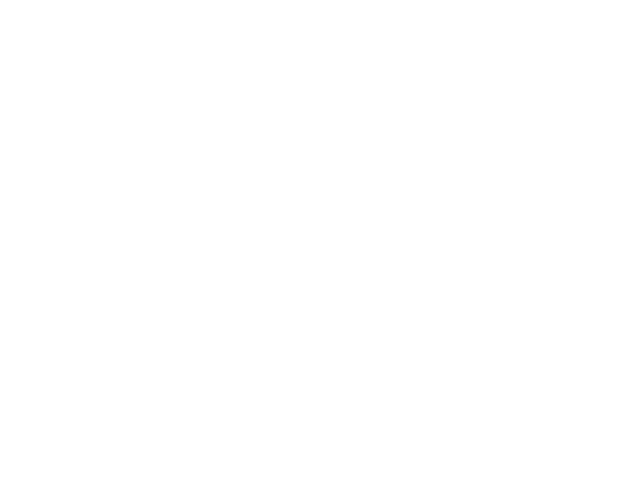

In [48]:
i = 1
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

#### Zestaw 3.

<IPython.core.display.Javascript object>


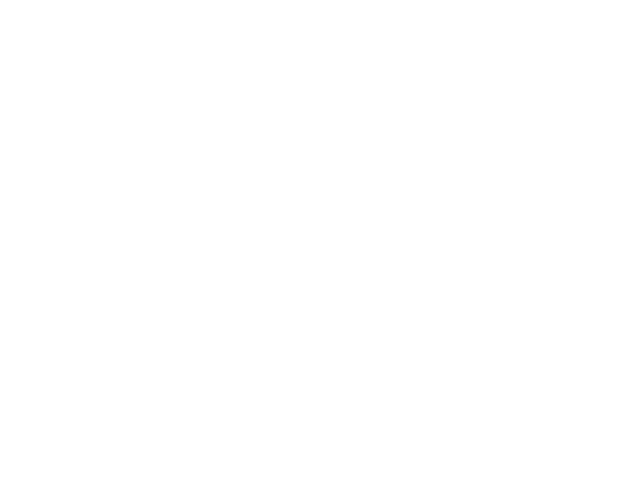

In [49]:
i = 2
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

#### Zestaw 4.

<IPython.core.display.Javascript object>


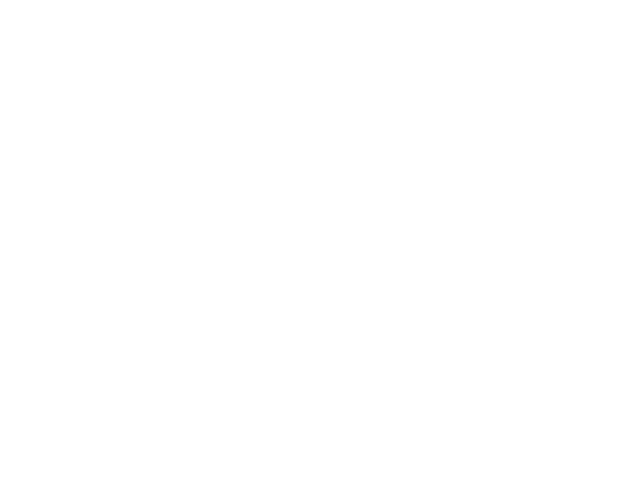

In [50]:
i = 3
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

### Algorytm Jarvisa

In [51]:
record = [jarvis_march(p) for p in set_of_points]

#### Zestaw 1.

<IPython.core.display.Javascript object>


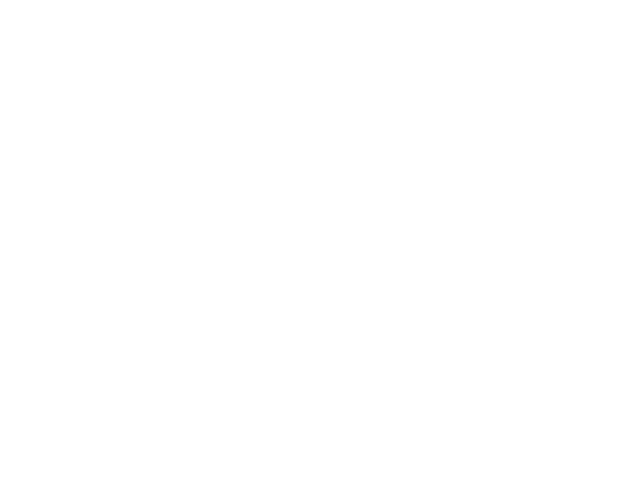

<IPython.core.display.Javascript object>


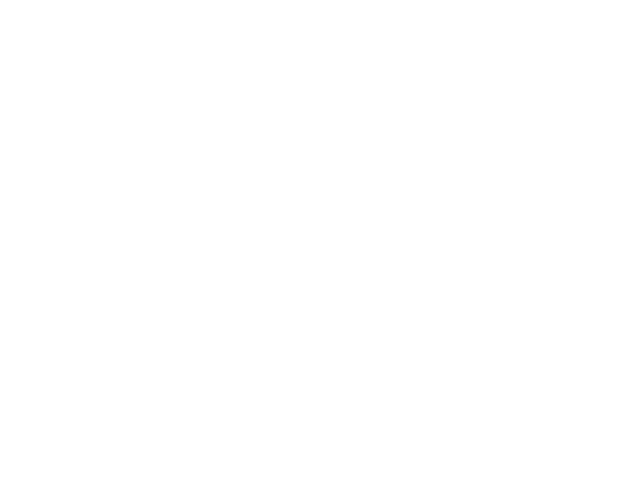

In [52]:
%matplotlib notebook
i = 0
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

#### Zestaw 2,

<IPython.core.display.Javascript object>


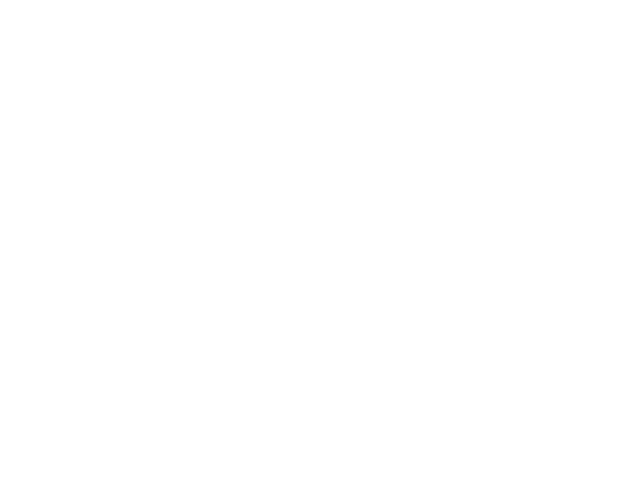

<IPython.core.display.Javascript object>


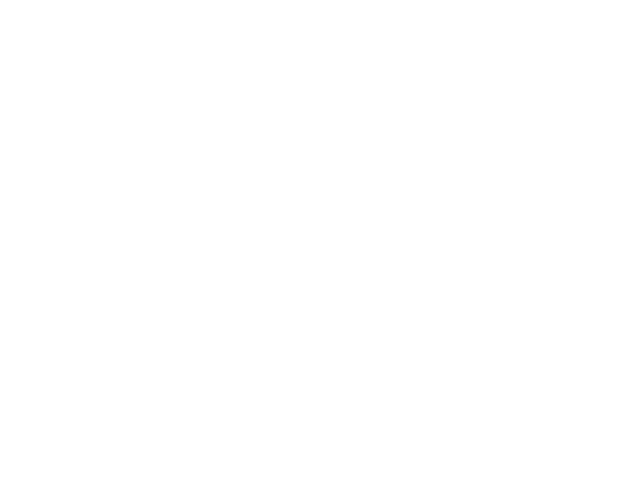

In [53]:
%matplotlib notebook
i = 1
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

#### Zestaw 3.

<IPython.core.display.Javascript object>


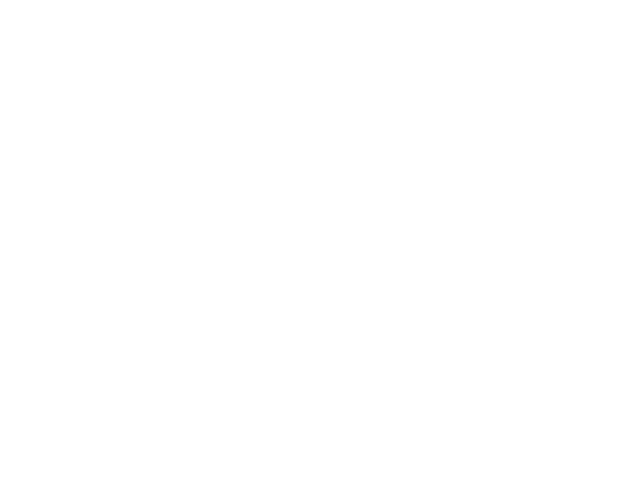

<IPython.core.display.Javascript object>


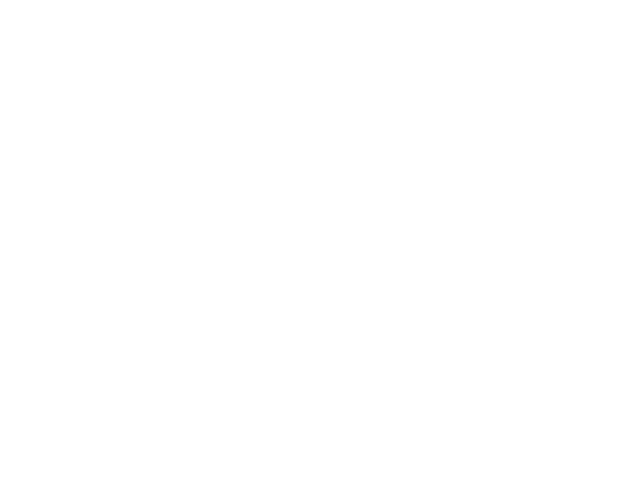

In [54]:
%matplotlib notebook
i = 2
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

#### Zestaw 4.

<IPython.core.display.Javascript object>


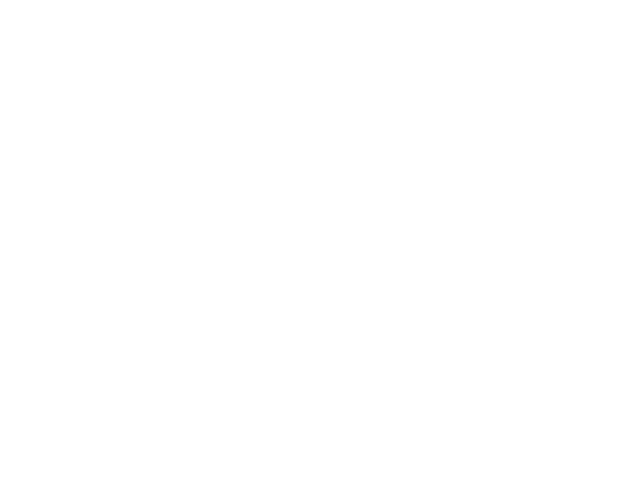

<IPython.core.display.Javascript object>


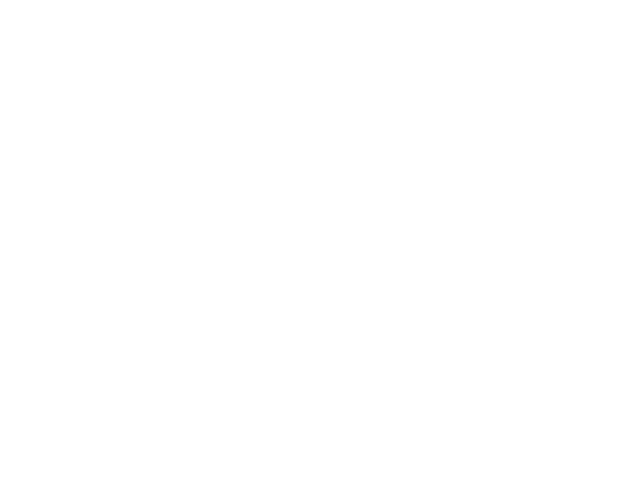

In [55]:
%matplotlib notebook
i = 3
hull, steps, t = record[i]
plot_hull(hull)
visualize(set_of_points[i], steps)

In [140]:
def time_diff(points_by_num):
    x_data = [len(points) for points in points_by_num]
    r_graham = [graham_scan(points)[2] for points in points_by_num]
    r_jarvis = [jarvis_march(points)[2] for points in points_by_num]
    
    return x_data, r_graham, r_jarvis
    
def plot_time_diff(data):
    x_data, graham_data, jarvis_data = data
    
    plt.style.use('ggplot')
    plt.xlabel('Liczba punktów')
    plt.ylabel('Czas wykonania algorytmu [s]')


    plt.plot(x_data, graham_data, label='Graham')
    plt.plot(x_data, jarvis_data, label='Jarvis')
    plt.legend()
    
def create_table_time_diff(data):
    x_data, graham_data, jarvis_data= data
    
    pd_data = [None for _ in range(2*(len(x_data)))]
    k = 0
    for i in range(len(x_data)):
        pd_data[k] = [graham_data[i]]
        k += 1
        pd_data[k] = [jarvis_data[i]]
        k += 1
    
    df = pd.DataFrame(pd_data, index=pd.MultiIndex.from_product([x_data, ['Graham Scan', 'Jarvis\'s March']], names=['Number of points', 'Algorithm']),
                     columns=pd.Index(['Time']))
    
    display.display(df)
    
    html = df.to_html()
  
    # zapisuję tabelę w pliku z rozszerzeniem .html
    text_file = open("index.html", "w")
    text_file.write(html)
    text_file.close()

<IPython.core.display.Javascript object>


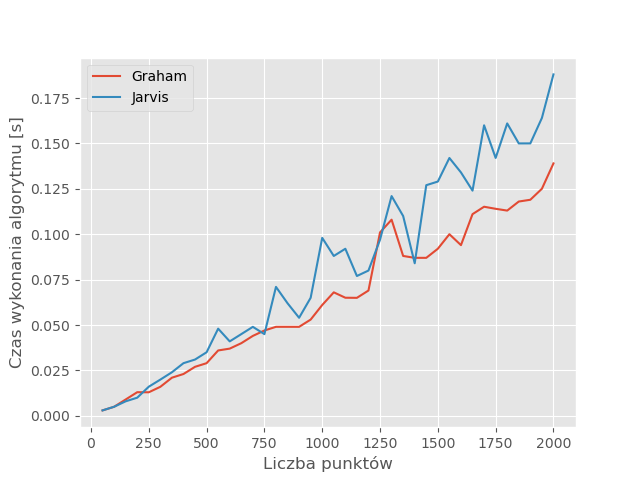

In [142]:
%matplotlib notebook
points_by_num = [generate_set_a(num) for num in np.arange(50, 2001, 50)]
time_data = time_diff(points_by_num)
plot_time_diff(time_data)

<IPython.core.display.Javascript object>


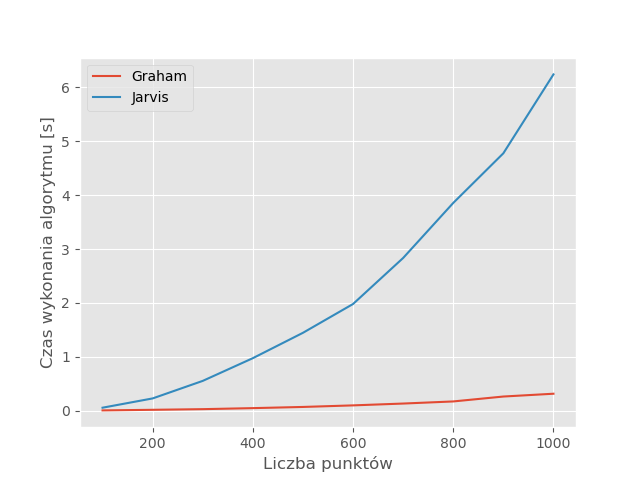

In [165]:
%matplotlib notebook
points_by_num = [generate_set_b(num) for num in np.arange(100, 1001, 100)]
time_data = time_diff(points_by_num)
plot_time_diff(time_data)

In [166]:
create_table_time_diff(time_data)

Time
Number of points Algorithm               
100              Graham Scan     0.008999
                 Jarvis's March  0.058975
200              Graham Scan     0.020000
                 Jarvis's March  0.231004
300              Graham Scan     0.031997
                 Jarvis's March  0.555996
400              Graham Scan     0.051024
                 Jarvis's March  0.976999
500              Graham Scan     0.073000
                 Jarvis's March  1.447025
600              Graham Scan     0.102000
                 Jarvis's March  1.980977
700              Graham Scan     0.135978
                 Jarvis's March  2.834003
800              Graham Scan     0.175000
                 Jarvis's March  3.853999
900              Graham Scan     0.266000
                 Jarvis's March  4.773999
1000             Graham Scan     0.318021
                 Jarvis's March  6.235977

In [ ]:
%matplotlib notebook
points_by_num = [generate_set_c(num) for num in np.arange(100, 20000, 100)]
time_data = time_diff(points_by_num)
plt.title('Zestaw 3.')
plot_time_diff(time_data)

<IPython.core.display.Javascript object>


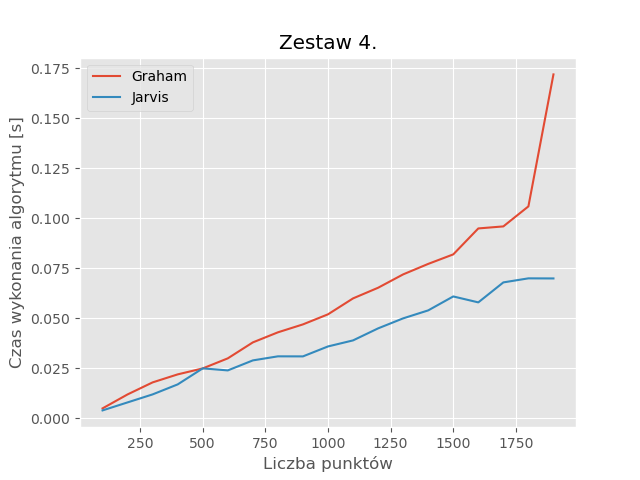

In [169]:
%matplotlib notebook
points_by_num = [generate_set_c(num) for num in np.arange(100, 2000, 100)]
time_data = time_diff(points_by_num)
plt.title('Zestaw 4.')
plot_time_diff(time_data)